In [1]:
import os
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
import time
import math
import tensorflow as tf
import torch.nn as nn
from keras.datasets import fashion_mnist
from numpy import sqrt

seed=97238684
np.random.seed(seed)
tf.random.set_seed(seed)
# np.random.seed(1234)
# tf.random.set_seed(1234)
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Load the MNIST dataset and define train, test and validation sets

In [3]:
size_input = 784
size_hidden1 = 512
size_hidden2 = 256
size_hidden3 = 128
size_output = 10
starter_learning_rate = 0.001
regularizer_rate = 0.1

#Load the FMNIST dataset and define train, test and validation sets


In [4]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(1-train_ratio))
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((test_ratio/(validation_ratio+test_ratio))))

X_train.shape

11501568/11490434 [==============================] - 0s 0us/step


(56000, 28, 28)

#Reshape the train, test and validation sets (MNIST)

In [5]:
(Xtrain_fmnist, ytrain_fmnist), (Xtest_fmnist, ytest_fmnist) = fashion_mnist.load_data()
X_fmnist = np.concatenate([Xtrain_fmnist, Xtest_fmnist])
y_fmnist = np.concatenate([ytrain_fmnist, ytest_fmnist])

Xtrain_fmnist, X_val_fmnist, ytrain_fmnist, y_val_fmnist = train_test_split(X_fmnist, y_fmnist, test_size=(1-train_ratio))
X_val_fmnist, Xtest_fmnist, y_val_fmnist, ytest_fmnist = train_test_split(X_val_fmnist, y_val_fmnist, test_size=((test_ratio/(validation_ratio+test_ratio))))

4431872/4422102 [==============================] - 0s 0us/step


In [6]:

# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = np.reshape(X_train, (56000, 784))
X_test = np.reshape(X_test, (-1, 784))
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
X_val = np.reshape(X_val, (7000,784))
X_val=X_val/255.0
X_val=tf.cast(X_val,dtype=tf.float32)
y_train = tf.one_hot(y_train,10)
y_test = tf.one_hot(y_test,10)

#Reshape the train, test and validation sets (FMNIST)

In [7]:
Xtrain_fmnist = np.reshape(X_train, (56000, 784))
Xtest_fmnist = np.reshape(X_test, (-1, 784))
Xtrain_fmnist = Xtrain_fmnist.astype(float) / 255
Xtest_fmnist = Xtest_fmnist.astype(float) / 255
X_val_fmnist = np.reshape(X_val_fmnist, (7000,784))
X_val_fmnist=X_val_fmnist.astype(float) /255.0
ytrain_fmnist = tf.one_hot(ytrain_fmnist,10)
ytest_fmnist = tf.one_hot(ytest_fmnist,10)

In [8]:
print(X_train.shape, y_train.shape)
print(Xtrain_fmnist.shape, ytrain_fmnist.shape)

(56000, 784) (56000, 10)
(56000, 784) (56000, 10)


In [9]:
# Split MNIST dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2)

In [10]:
# Split FMNIST dataset into batches
train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).batch(16)
test_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtest_fmnist, ytest_fmnist)).batch(4)
val_ds_fmnist = tf.data.Dataset.from_tensor_slices((X_val_fmnist, y_val_fmnist)).batch(2)

#Build MLP using Eager Execution with Dropout

In [11]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    self.W_h1 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
     # Initialize weights between hidden layer and output layer
    self.W_h2 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3]))
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden3]))
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W_h1, self.W_h2, self.W2, self.b1, self.b2, self.b3, self.b4]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true)) \
    #     + regularizer_rate*(tf.reduce_sum(tf.square(self.b1)) + tf.reduce_sum(tf.square(self.b2)) + \
    #                         tf.reduce_sum(tf.square(self.b3)) + tf.reduce_sum(tf.square(self.b4)) + \
    #                         tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W_h1) + tf.nn.l2_loss(self.W_h2) + tf.nn.l2_loss(self.W2) )
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true))
    # return loss
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # Compute values in hidden layer
    what_i = tf.matmul(X_tf, self.W1) + self.b1
    hhat_i = tf.nn.relu(what_i)
    drop_out = tf.nn.dropout(hhat_i, 0.2)
    what_h1 = tf.matmul(drop_out, self.W_h1) + self.b2
    hhat_h1 = tf.nn.relu(what_h1)
    drop_out1 = tf.nn.dropout(hhat_h1, 0.2)
    what_h2 = tf.matmul(drop_out1, self.W_h2) + self.b3
    hhat_h2 = tf.nn.relu(what_h2)
    drop_out2 = tf.nn.dropout(hhat_h2, 0.2)


    output = tf.matmul(drop_out2, self.W2) + self.b4
    output = tf.nn.softmax(output)
   
    return output

    # Calculate standard error
  def stderr(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    std_err = std_dev/sqrt(len(y_pred_tf))
    return std_err 

 # Calculate variance error
  def var(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    variance = (std_dev**2) # calculate variance
    return variance 


#Train Model

In [12]:
# Set number of epochs
NUM_EPOCHS = 10

In [13]:
# Initialize model using GPU MNIST Data on train data

mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("model using CPU MNIST Data Without Regularization on Train data")
time_start = time.time()
acc_mnist_train=[]
acc_mnist_test=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_train=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy_train=tf.keras.metrics.CategoricalAccuracy()
    accuracy_train.update_state(preds, outputs)
  acc_mnist_train.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], accuracy_train.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using CPU MNIST Data Without Regularization on Train data
Number of Epoch = 1 - Average Cross Entropy:= 0.023666881016322545, Accuracy:= 8.0
Number of Epoch = 2 - Average Cross Entropy:= 0.023673001970563615, Accuracy:= 10.0
Number of Epoch = 3 - Average Cross Entropy:= 0.02369852120535714, Accuracy:= 7.0
Number of Epoch = 4 - Average Cross Entropy:= 0.023697906494140625, Accuracy:= 7.0
Number of Epoch = 5 - Average Cross Entropy:= 0.023660609654017856, Accuracy:= 12.0
Number of Epoch = 6 - Average Cross Entropy:= 0.023674894060407365, Accuracy:= 8.0
Number of Epoch = 7 - Average Cross Entropy:= 0.02369165257045201, Accuracy:= 10.0
Number of Epoch = 8 - Average Cross Entropy:= 0.02368571254185268, Accuracy:= 8.0
Number of Epoch = 9 - Average Cross Entropy:= 0.023649187360491073, Accuracy:= 11.0
Number of Epoch = 10 - Average Cross Entropy:= 0.023681348528180803, Accuracy:= 10.0

Total time taken (in seconds): 132.57


In [14]:
# Initialize model using GPU MNIST Data With Dropout on Test data

mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("model using GPU MNIST Data With Dropout on Test data")
time_start = time.time()
acc_mnist_test=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_test=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in test_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy_test=tf.keras.metrics.CategoricalAccuracy()
    accuracy_test.update_state(preds, outputs)
  acc_mnist_test.append(np.sum(loss_total) / X_test.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_test.shape[0], accuracy_test.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using GPU MNIST Data With Dropout on Test data
Number of Epoch = 1 - Average Cross Entropy:= 0.5909325474330357, Accuracy:= 25.0
Number of Epoch = 2 - Average Cross Entropy:= 0.59166015625, Accuracy:= 25.0
Number of Epoch = 3 - Average Cross Entropy:= 0.5905032784598214, Accuracy:= 25.0
Number of Epoch = 4 - Average Cross Entropy:= 0.5897181222098214, Accuracy:= 25.0
Number of Epoch = 5 - Average Cross Entropy:= 0.5912550920758929, Accuracy:= 0.0
Number of Epoch = 6 - Average Cross Entropy:= 0.5900055106026786, Accuracy:= 0.0
Number of Epoch = 7 - Average Cross Entropy:= 0.5902905970982143, Accuracy:= 0.0
Number of Epoch = 8 - Average Cross Entropy:= 0.5898265904017858, Accuracy:= 25.0
Number of Epoch = 9 - Average Cross Entropy:= 0.58939794921875, Accuracy:= 25.0
Number of Epoch = 10 - Average Cross Entropy:= 0.5908976004464286, Accuracy:= 50.0

Total time taken (in seconds): 374.66


In [15]:
# Initialize model using GPU MNIST Data With Dropout on Test data

mlp_on_tpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')
print("model using GPU MNIST Data With Dropout on Test data")
time_start = time.time()
acc_mnist_test_tpu=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_test_tpu=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in test_ds:
    preds = mlp_on_tpu.forward(inputs)
    loss_total = loss_total + mlp_on_tpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_tpu.backward(inputs, outputs)
    accuracy_test_tpu=tf.keras.metrics.CategoricalAccuracy()
    accuracy_test_tpu.update_state(preds, outputs)
  acc_mnist_test_tpu.append(np.sum(loss_total) / X_test.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_test.shape[0], accuracy_test_tpu.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using GPU MNIST Data With Dropout on Test data
Number of Epoch = 1 - Average Cross Entropy:= 0.5912547433035714, Accuracy:= 25.0
Number of Epoch = 2 - Average Cross Entropy:= 0.5887556501116071, Accuracy:= 0.0
Number of Epoch = 3 - Average Cross Entropy:= 0.5899688197544642, Accuracy:= 25.0
Number of Epoch = 4 - Average Cross Entropy:= 0.5888635602678571, Accuracy:= 25.0
Number of Epoch = 5 - Average Cross Entropy:= 0.5900394112723214, Accuracy:= 25.0
Number of Epoch = 6 - Average Cross Entropy:= 0.5889372907366072, Accuracy:= 25.0
Number of Epoch = 7 - Average Cross Entropy:= 0.59061279296875, Accuracy:= 25.0
Number of Epoch = 8 - Average Cross Entropy:= 0.588923828125, Accuracy:= 25.0
Number of Epoch = 9 - Average Cross Entropy:= 0.5896847098214286, Accuracy:= 25.0
Number of Epoch = 10 - Average Cross Entropy:= 0.5887389090401786, Accuracy:= 25.0

Total time taken (in seconds): 502.54


In [16]:
# Initialize model using GPU Fashion MNIST Data With Dropout on train data

mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("model using GPU Fashion MNIST Data With Dropout on Train data")
time_start = time.time()
acc_fmnist_train=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accu_train_fmnist=0
  train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_gpu.forward(inputs)
    loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accu_train_fmnist=tf.keras.metrics.CategoricalAccuracy()
    accu_train_fmnist.update_state(preds, outputs)
  acc_fmnist_train.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtrain_fmnist.shape[0], accu_train_fmnist.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using GPU Fashion MNIST Data With Dropout on Train data
Number of Epoch = 1 - Average Cross Entropy:= 0.02361220223563058, Accuracy:= 12.0
Number of Epoch = 2 - Average Cross Entropy:= 0.023581202915736607, Accuracy:= 11.0
Number of Epoch = 3 - Average Cross Entropy:= 0.023590138026646206, Accuracy:= 9.0
Number of Epoch = 4 - Average Cross Entropy:= 0.023601412091936384, Accuracy:= 11.0
Number of Epoch = 5 - Average Cross Entropy:= 0.02361309596470424, Accuracy:= 18.0
Number of Epoch = 6 - Average Cross Entropy:= 0.023599321637834823, Accuracy:= 11.0
Number of Epoch = 7 - Average Cross Entropy:= 0.023613743373325894, Accuracy:= 9.0
Number of Epoch = 8 - Average Cross Entropy:= 0.02363609313964844, Accuracy:= 10.0
Number of Epoch = 9 - Average Cross Entropy:= 0.023594835553850446, Accuracy:= 13.0
Number of Epoch = 10 - Average Cross Entropy:= 0.02360697283063616, Accuracy:= 10.0

Total time taken (in seconds): 121.45


In [17]:
# Initialize model using GPU Fashion MNIST Data With Dropout on train data

mlp_on_tpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')
print("model using TPU Fashion MNIST Data With Dropout on Test data")
time_start = time.time()

acc_fmnist_test=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accu_test_fmnist=0
  test_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtest_fmnist, ytest_fmnist)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in test_ds_fmnist:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_tpu.loss(preds, outputs)
    lt = lt + mlp_on_tpu.loss(preds, outputs)
    mlp_on_tpu.backward(inputs, outputs)
    accu_test_fmnist=tf.keras.metrics.CategoricalAccuracy()
    accu_test_fmnist.update_state(preds, outputs)
  acc_fmnist_test.append(np.sum(loss_total) / Xtest_fmnist.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtest_fmnist.shape[0], accu_test_fmnist.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using TPU Fashion MNIST Data With Dropout on Test data
Number of Epoch = 1 - Average Cross Entropy:= 0.023594876970563616, Accuracy:= 10.0
Number of Epoch = 2 - Average Cross Entropy:= 0.023615543910435268, Accuracy:= 13.0
Number of Epoch = 3 - Average Cross Entropy:= 0.02356805637904576, Accuracy:= 9.0
Number of Epoch = 4 - Average Cross Entropy:= 0.023588668823242186, Accuracy:= 8.0
Number of Epoch = 5 - Average Cross Entropy:= 0.02359183829171317, Accuracy:= 12.0
Number of Epoch = 6 - Average Cross Entropy:= 0.023576119559151787, Accuracy:= 8.0
Number of Epoch = 7 - Average Cross Entropy:= 0.023568675449916296, Accuracy:= 6.0
Number of Epoch = 8 - Average Cross Entropy:= 0.023647859845842632, Accuracy:= 11.0
Number of Epoch = 9 - Average Cross Entropy:= 0.023590571812220983, Accuracy:= 13.0
Number of Epoch = 10 - Average Cross Entropy:= 0.023639277866908483, Accuracy:= 11.0

Total time taken (in seconds): 21.64


In [18]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0,dtype=tf.float32)
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  # print(preds)
  b = mlp_on_cpu.loss(preds, outputs)
  standard_error = mlp_on_cpu.stderr(preds) 
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  Variance = mlp_on_cpu.var(preds) 

  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])==tf.argmax(outputs[i]):
      acc_preds = acc_preds + 1.0
acc = (acc_preds/X_test.shape[0])*100.0
print('Inference for Test Data With Dropout')
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/X_train.shape[0]))
print('Accuracy: {:.4f}'.format(acc))
print('Standard Error: {:.4f}'.format(standard_error))
print('Variance: {:.4f}'.format(Variance))

print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))

Inference for Test Data With Dropout
Test MSE: 0.0739
Accuracy: 9.7857
Standard Error: 0.1500
Variance: 0.0900
Test MSE: 0.0739


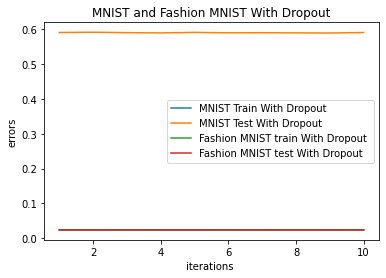

In [20]:
# Plot learning curve (with errors)
import matplotlib.pyplot as plt
%matplotlib inline
iterations = [1,2,3,4,5,6,7,8,9,10]
errors_train = np.squeeze(acc_mnist_train)
errors_test = np.squeeze(acc_mnist_test)
errors_train1 = np.squeeze(acc_fmnist_train)
errors_test1 = np.squeeze(acc_fmnist_test)
# errors_test2 = np.squeeze(acc_fmnist_test_tpu)
plt.plot(iterations,errors_train,label='MNIST Train With Dropout')
plt.plot(iterations,errors_test,label='MNIST Test With Dropout ')
plt.plot(iterations,errors_train1,label='Fashion MNIST train With Dropout ')
plt.plot(iterations,errors_test1,label='Fashion MNIST test With Dropout')
# plt.plot(iterations,errors_test2,label='Fashion MNIST test With Dropout TPU')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("MNIST and Fashion MNIST With Dropout")
plt.legend()
plt.show()